# Tutorial 4: Peak selection analysis

Here we will use scATAC-seq dataset `10XBlood' as an example to train scAGDE and analyse the peak importance scores model have learned.

## 1. Train scAGDE

First we train scAGDE on the 10XBlood dataset following [Tutorial 1: End-to-end scATAC-seq analysis](./Tutorial%201:%20End-to-end%20scATAC-seq%20analysis.ipynb).

In [3]:
import scanpy as sc
adata = sc.read_h5ad("data/10XBlood.h5ad")

<div class="alert alert-block alert-info">
<b>Note:</b> Here, we specify the parameter `save_epoch=10`, meaning that the model will save the importance scores for each peak every 10 epochs during autoencoder training. These CSV files will be saved in the "weights" folder within `outdir`. As a result, upon completion of the training (with a total of 5000 epochs), there will be 500 CSV files in folder named as "output/weights".
</div>


In [4]:
import scAGDE
trainer = scAGDE.Trainer(adata,outdir="output",n_centroids=9,gpu="3",save_epoch=10)
adata = trainer.fit(topn=10000)
print(adata)

device used: cuda:3

Cell number: 17736
Peak number: 39565
n_centroids: 9




## Training CountModel ##


CountModel: 100%|██████████| 5000/5000 [13:49<00:00,  6.03it/s, loss=12509.2070]



## Constructing Cell Graph ##
Cell number: 17736
Peak number: 10000
n_centroids: 9


## Training GraphModel ##


GraphModel: 100%|██████████| 4000/4000 [08:10<00:00,  8.15it/s, loss=6096.3760]
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



AnnData object with n_obs × n_vars = 17736 × 39565
    obs: 'orig.ident', 'nCount_scATACseq', 'nFeature_scATACseq', 'celltype', 'n_genes', 'cluster'
    var: 'features', 'n_cells', 'is_selected'
    uns: 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'latent_init', 'impute', 'latent'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


We extract and save a subset containing only the peaks selected by scAGDE. Additionally, we save the names of the selected peaks as well as all original peak names, which will be used in subsequent analyses.

In [5]:
adata[:,adata.var["is_selected"]==1].write("output/adata.h5ad",compression="gzip")
import pandas as pd
selected_peak = adata.var_names[adata.var["is_selected"]==1].values
selected_peak = pd.DataFrame(selected_peak, columns=["peaks"])
selected_peak.to_csv("output/selected_peaks.csv", index=False)
all_peak = adata.var_names.values
all_peak = pd.DataFrame(all_peak, columns=["peaks"])
all_peak.to_csv("output/all_peaks.csv", index=False)

/home/haogaoyang/anaconda3/envs/torch/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


## 2. Further analysis (accessibility statistics and annotation)

We have developed several R scripts to perform downstream analyses, and the essential code for key analyses is provided below. To interactively execute the analysis within this notebook, we utilize the [rpy2](https://github.com/rpy2/rpy2) package, which allows running R code directly. Thus, please ensure that rpy2 is installed. Alternatively, you may extract these R scripts and execute them externally as standalone R scripts. 

The code below initializes rpy2. After this setup, you can write and execute R code directly within notebook cells by starting with `%%R`.

In [7]:
import logging
import rpy2.rinterface_lib.callbacks
from rpy2.robjects import pandas2ri
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
pandas2ri.activate()
%load_ext rpy2.ipython

In [ ]:
import logging
import rpy2.rinterface_lib.callbacks
from rpy2.robjects import pandas2ri
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
pandas2ri.activate()
%load_ext rpy2.ipython

To completely finish the following analysis, you need requires specific R packages listed below (`pkgs`), and you can verify and install using the code provided below.

In [56]:
%%R

pkgs <- c(
    "dplyr",
    "hexbin",
    "entropy",
    "Seurat",
    "Signac",
    "ggplot2",
    "viridis",
    "circlize",
    "ggprism",
    "ComplexHeatmap",
    "TxDb.Hsapiens.UCSC.hg19.knownGene",
    "org.Hs.eg.db",
    "data.table",
    "stringr",
    "ggalluvial",
    "ggprism",
    "ChIPseeker"
)
######## Install all packages using codes below ########
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
# BiocManager::install(pkgs)
suppressWarnings(suppressPackageStartupMessages(lapply(pkgs,library,character.only=TRUE)))

[[1]]
 [1] "ComplexHeatmap"                    "grid"                             
 [3] "circlize"                          "stringr"                          
 [5] "data.table"                        "ggprism"                          
 [7] "ggalluvial"                        "org.Hs.eg.db"                     
 [9] "TxDb.Hsapiens.UCSC.hg19.knownGene" "GenomicFeatures"                  
[11] "AnnotationDbi"                     "Biobase"                          
[13] "GenomicRanges"                     "GenomeInfoDb"                     
[15] "IRanges"                           "S4Vectors"                        
[17] "stats4"                            "BiocGenerics"                     
[19] "ChIPseeker"                        "viridis"                          
[21] "viridisLite"                       "ggplot2"                          
[23] "dplyr"                             "entropy"                          
[25] "SeuratObject"                      "Seurat"                     

 "grDevices"                         "utils"                            
[33] "datasets"                          "methods"                          
[35] "base"                             

[[2]]
 [1] "hexbin"                            "ComplexHeatmap"                   
 [3] "grid"                              "circlize"                         
 [5] "stringr"                           "data.table"                       
 [7] "ggprism"                           "ggalluvial"                       
 [9] "org.Hs.eg.db"                      "TxDb.Hsapiens.UCSC.hg19.knownGene"
[11] "GenomicFeatures"                   "AnnotationDbi"                    
[13] "Biobase"                           "GenomicRanges"                    
[15] "GenomeInfoDb"                      "IRanges"                          
[17] "S4Vectors"                         "stats4"                           
[19] "BiocGenerics"                      "ChIPseeker"                       
[21] "viridis"                  

### 3.1 Statistical analysis of selected peaks

Here, we selected 10,000 peaks from the preprocessed 10XBlood dataset using scAGDE, to determine the accessibility of human immune cells and analyze their accessibility-related statistics. Specifically, after identifying the peaks from scAGDE, we generated pseudo-bulk data by merging the accessibility profiles of each peak across different cell types, resulting in a summarized accessibility profile for each peak within nine distinct cell types. 


Based on this pseudo-bulk data, we calculated the median accessibility and the range (the difference between the maximum and minimum accessibility values across cell types) for each peak. Additionally, we measured the Shannon entropy of each peak and the percentage of cells where each peak is accessible. 

- ***How to read AnnData data object in R?***

First, we will convert Python objects into data formats required by R. Specifically, we will convert an `AnnData` object to a Seurat object and save it as an `.rds` file. Here, we use the `sceasy` package to perform this task; however, you may opt for any other method you are comfortable with.

In [9]:
%%R
sceasy::convertFormat("output/adata.h5ad", from = "anndata", to = "seurat", outFile = "output/adata.rds")


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    An object of class Seurat 
10000 features across 17736 samples within 1 assay 
Active assay: RNA (10000 features, 0 variable features)
 2 layers present: counts, data
 6 dimensional reductions calculated: pca, tsne, umap, impute, latent, latent_init


Next, let we example the correct data object in R.

In [10]:
%%R
obj <- readRDS("output/adata.rds")
obj


An object of class Seurat 
10000 features across 17736 samples within 1 assay 
Active assay: RNA (10000 features, 0 variable features)
 2 layers present: counts, data
 6 dimensional reductions calculated: pca, tsne, umap, impute, latent, latent_init


- ***How to calculate the statistics descirbed above in R?***

In [8]:
%%R
peakData <- function(atac_matrix,peaks,cell_types){
  # creation of data frame, including counts matrix and cell cluster
  peak_data <- atac_matrix[peaks, ] 
  peak_data <- data.frame(
    cell_type = cell_types,
    counts = t(as.matrix(peak_data))
  )
  # data summary
  peak_data <- peak_data %>%
    group_by(cell_type) %>%
    summarize(across(everything(), sum))
  peak_data <- as.data.frame(peak_data)
  rownames(peak_data) <- peak_data$cell_type
  peak_data$cell_type <- NULL
  peak_data <- as.data.frame(t(peak_data))
  df.media <- peak_data %>%
    rowwise() %>%
    summarize(
      median_count = median(c_across(everything())),  # meidan
      range_count = max(c_across(everything())) - min(c_across(everything()))  # range
    )
  # Shannon entropy
  entropy_values <- apply(peak_data, 1, function(row) {
    entropy(row)  
  })
  # accessible percentage
  accessibility_percentage <- apply(atac_matrix[peaks, ], 1, function(row) {
    sum(row > 0) / length(row)  
  })
  # resulting data frame
  df.shannon <- data.frame(
    peak = peaks,
    shannon_entropy = entropy_values,
    accessibility_percentage = accessibility_percentage,
    count = rowSums(atac_matrix[peaks,])
  )
  return(list(df.media = df.media, df.shannon = df.shannon))
}

%%R
library(Seurat)
library(entropy) 
library(dplyr) 
cell_types <- obj$celltype
atac_matrix <-as.matrix(GetAssayData(obj, slot = "counts"))
peaks.scAGDE <- read.csv("output/selected_peaks.csv",header=T)$peaks
df.scAGDE <- peakData(atac_matrix,peaks.scAGDE,cell_types)

- ***How to plot the statistics?***

In [ ]:
%%R
# plotting function
densityPlot <- function(df,optionColor="D",labs=c("Range of Chromatin Accessibility","Median Chromatin Accessibility"),theme=NULL){
  ggplot(df, aes(x = x, y = y)) +
    scale_fill_viridis(option = optionColor) +
    stat_density2d(aes(fill = ..density..), geom = "raster", contour = F,n=200, na.rm = FALSE,)+
    theme_light() +
    scale_x_continuous(expand = c(0,0), limits = c(3.2, 8))+
    scale_y_continuous(expand = c(0,0), limits = c(0, 1700))+
    labs(x = labs[1], y = labs[2])+
    coord_cartesian()+
    theme(
      plot.margin = margin(b=65,l=0,r=0),
      axis.text = element_text(size=14,color = "black"),
    )+
    theme
}
hexPlot <- function(df,optionColor="D",labs=c("accessibility percentage","shannon entropy"),theme=NULL){
  ggplot(df, aes(x = x, y = y)) +
    geom_hex(bins=35,color="lightgrey") +
    scale_fill_viridis(option = optionColor)+
    theme_light() +
    theme(
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
    )+
    scale_x_continuous(limits = c(0, 1))+
    scale_y_continuous(limits = c(0, 2.3))+
    theme(
      panel.border = element_rect(linewidth = 1,color="black",fil=NA),
      axis.text = element_text(size=14,color = "black"),
    )+
    labs(x = labs[1], y = labs[2])
}

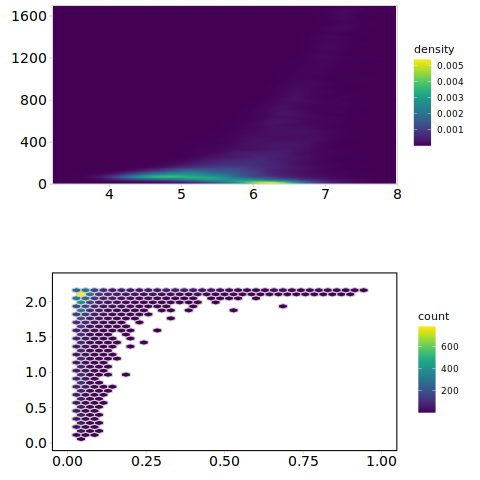

In [12]:
%%R
library(ggplot2) 
library(viridis) 
df.use <- df.scAGDE$df.media;df.use$x <- log(df.use$range_count);df.use$y <- df.use$median_count;
p.den <- densityPlot(df.use,labs=c(NULL,NULL))
df.use <- df.scAGDE$df.shannon;df.use$x <- df.use$accessibility_percentage;df.use$y <- df.use$shannon_entropy;
p.hex <- hexPlot(df.use,labs=c(NULL,NULL))
p <- p.den+p.hex+patchwork::plot_layout(byrow=F,heights = c(1,1), ncol=1)
p <- p.den+p.hex+patchwork::plot_layout(byrow=F,heights = c(1,1), ncol=1)
p

As a result, the peaks identified by scAGDE exhibited low accessibility and large range of accessibility variability. Additionally, we observed an increase in the number of peaks with lower Shannon entropy and a smaller percentage of accessibility, alongside a decrease in peaks with high Shannon
entropy, indicating that scAGDE tended to select cell type-specific accessible peaks.

### 3.2 Peak annotation

To further dissect the identity of these candidate peaks, we annotated them with peak type using [ChIPseeker](https://github.com/YuLab-SMU/ChIPseeker) based on their proximity to the nearest transcription start sites (TSS). 

In [13]:
%%R
library(ChIPseeker)
library(TxDb.Hsapiens.UCSC.hg19.knownGene)
library(org.Hs.eg.db)
library(Signac)
peakAnno.scAGDE <- annotatePeak(
  StringToGRanges(peaks.scAGDE),
  tssRegion = c(-3000, 3000),
  TxDb =TxDb.Hsapiens.UCSC.hg19.knownGene,
  annoDb = 'org.Hs.eg.db')
peakTypes.scAGDE <- peakAnno.scAGDE@annoStat
peakTypes.scAGDE$group <- "scAGDE"
df <- peakTypes.scAGDE

>> preparing features information...		 2024-11-11 06:25:50 AM 
>> identifying nearest features...		 2024-11-11 06:25:50 AM 
>> calculating distance from peak to TSS...	 2024-11-11 06:25:50 AM 
>> assigning genomic annotation...		 2024-11-11 06:25:50 AM 
>> adding gene annotation...			 2024-11-11 06:26:00 AM 
>> assigning chromosome lengths			 2024-11-11 06:26:00 AM 
>> done...					 2024-11-11 06:26:00 AM 


Let's plot the annotatation results.

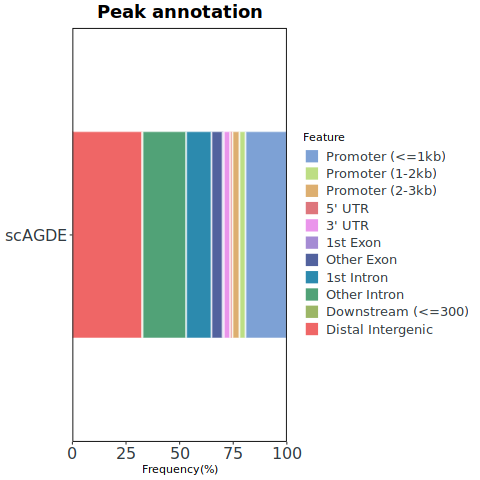

In [14]:
%%R
library(ggalluvial)
library(ggprism)
library(ggplot2)
ggplot(df, aes(x = group,y=Frequency,fill = Feature,
                       stratum = Feature, alluvium = Feature))+
  geom_stratum(width = 0.6, color='white')+
  geom_alluvium(
    alpha = 0.3,#透明度
                width = 0.6,#宽度
                color='white',#间隔颜色
                size = 1,#间隔宽度
                curve_type = "linear"
    )+
  scale_y_continuous(expand = c(0,0))+
  labs(x=NULL,y="Frequency(%)",
       fill="Feature")+
  scale_fill_manual(values = c(ggprism_data$fill_palettes$summer,"#f06667"))+
  theme_bw()+
  theme(panel.grid=element_blank(),
        plot.title = element_text(size=18,face = "bold",colour = "black",hjust=.5),
        panel.border = element_rect(fill=NA,color="black",linewidth = .85),
        axis.text=element_text(color='#333c41',size=16 ),
        legend.text = element_text(color='#333c41',size=13))+
  ggtitle("Peak annotation")+
  coord_flip()

### 3.3 Peak importance analysis

To illustrate our model's preferences on peak selection, we uniformly sampled 500 moments from the entire training process of our autoencoder model, and computed the importance scores of all peaks at each moment. To characterize the distinct preference patterns, we organized the 39,565 peak importance profiles into 6 modules by K-means clustering based on the elbow method.

- ***How to read peak importance scores in R?***

In [15]:
%%R
library(data.table)
library(stringr)

file_path <- "output/weights/"
# Get the filenames of all CSV files
csv_files <- list.files(file_path, pattern = "*.csv", full.names = TRUE)
csv_files <- stringr::str_sort(csv_files,numeric = T)
# Read each CSV file in order and merge them into a dataframe
data_list <- lapply(csv_files, function(file) {
  # read.csv(file, header = FALSE)  # 假设没有列名
  t(fread(file, header = FALSE))  # 假设没有列名
})
# Bind all columns into a dataframe, with each file's data becoming a column
final_data <- do.call(cbind, data_list)
dim(final_data)


[1] 39565   500


Next, let's annotate all the peaks using ChIPseeker again.

In [51]:
%%R
library(TxDb.Hsapiens.UCSC.hg19.knownGene)
library(org.Hs.eg.db)

peaks <- read.csv("output/all_peaks.csv",header=T)$peaks
attention <- as.data.frame(final_data)
rownames(attention) <- peaks
peaks <- Signac::StringToGRanges(peaks,sep=c("-","-"))
peaks <- Signac::StringToGRanges(rownames(attention))
peakAnno <- annotatePeak(
  peaks,
  tssRegion = c(-3000, 3000),
  TxDb =TxDb.Hsapiens.UCSC.hg19.knownGene,
  annoDb = 'org.Hs.eg.db')
peakAnno.df <- as.data.frame(peakAnno)
peakTypes <- peakAnno@annoStat
peakTypes <- peakTypes %>%
  arrange(dplyr::desc(Feature)) %>%
  mutate(lab.ypos = cumsum(Frequency) - 0.5*Frequency)
types <- gsub("^(Exon|Intron)\\s*\\(.*\\)", "\\1", peakAnno@anno$annotation)
attention$type <- types
attention <- attention[order(types),]


>> preparing features information...		 2024-11-11 07:18:12 AM 
>> identifying nearest features...		 2024-11-11 07:18:12 AM 
>> calculating distance from peak to TSS...	 2024-11-11 07:18:13 AM 
>> assigning genomic annotation...		 2024-11-11 07:18:13 AM 
>> adding gene annotation...			 2024-11-11 07:18:15 AM 
>> assigning chromosome lengths			 2024-11-11 07:18:15 AM 
>> done...					 2024-11-11 07:18:15 AM 


- ***How to plot these score, alongside the annotation information in a single heatmap?***

In [53]:
%%R
library(circlize)
library(ggprism)
library(ComplexHeatmap)

set.seed(10)
data <- attention[,-ncol(attention)]
km <- kmeans(scale(data),6)
cls <- km$cluster

sorted_clusters <- order(table(cls))
new_cls <- cls
for (i in seq_along(sorted_clusters)) {
  new_cls[cls == sorted_clusters[i]] <- i
}
new_cls <- setNames(paste0("M",new_cls),names(new_cls))


mycols <- colorRamp2(breaks = c(-2, 0, 2), colors = c("#5100bd", "white", "darkred"))
cols <- setNames(ggprism_data$fill_palettes$summer[1:9],unique(attention$type))

col_fun <- function(at){cols[at]}
lgd = Legend(
  title = "Peak annotation",
  legend_gp = gpar(fill = col_fun(1:9)),
  labels = names(cols),
  at=1:9
)
data.ha <- apply(data,2,var)
ha = HeatmapAnnotation(variation = anno_lines(data.ha), height = unit(3, "cm"))


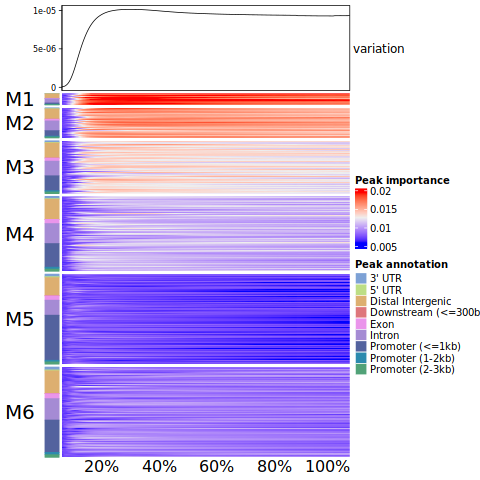

In [54]:
%%R
p <- Heatmap(
  data, name = "Peak importance",
  show_column_names = T,
  show_row_names = F,
  cluster_rows = F,
  split = new_cls,row_title_rot = 0,
  cluster_columns = F,
  left_annotation = rowAnnotation(peak = anno_simple(attention$type,col=cols),
                                  show_legend = T,show_annotation_name =F),
  top_annotation = ha,
  row_title_gp = gpar(fontsize=20),
  column_labels = c(rep("",99),"20%",rep("",99),"40%",rep("",99),"60%",rep("",99),"80%",rep("",99),"100%"),
  column_names_side = "bottom",column_names_rot = 0,column_names_gp = gpar(fontsize = 16),
)
draw(p,annotation_legend_list = list(lgd),merge_legend = TRUE)

As a result, the identified 6 modules have similar internal distribution and are distinct from each other. Specifically, at the initial stage, these modules exhibited a nearly uniform distribution and as the training progressed, the first two modules (M1 and M2) received increasing attention, whereas other modules, particularly M6, garnered less focus. The variation in peak importance scores are greatest at the 20\% stage and gradually stabilize as the model converged. As expected, M1 and M2 were primarily composed of peaks from intronic and distal intergenic regions, and near half of M6 composed of promoter peaks.